# Spinal cord injury analysis

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.api import OLS
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.tools.tools import add_constant

## Dataset

The data comes from the National Spinal Cord Injury Statistical Center (NSCISC).

Unpack it a `data` directory as follows for scripts to find it:
```
data
├── f1_public_2021.csv
└── f2_public_2021.csv
```

The two files contain responses to two forms, f1 and f2. The first form is administered at injury time. The second is recurring, first one year after the injury, then five, then every five years after this.

The vast majority of columns are categories whose definitions are given in a data dictionary, but we keep them as strings and integers for now to facilitate computations. The columns explicitely listed below contain a mix of integers and strings (e.g. `32` and `"6-12y"`) so we import them as strings to avoid warnings.

In [2]:
df1 = pd.read_csv(
    "data/f1_public_2021.csv",
    dtype={
        col_name: str for col_name in ["AExtCsIj", "AASAImAd", "AASAImDs", "AInjAge"]
    },
)
df2 = pd.read_csv(
    "data/f2_public_2021.csv",
    dtype={col_index: str for col_index in ["BASAImp"]},
)

The two forms have a single column in common, a unique ID per patient called `UniID`, so we can merge them into a single long-form dataframe.

In [3]:
df = pd.merge(df2, df1, on="UniID", how="left")

Let's look at how many records we're starting with:

In [4]:
df1.shape[0], df2.shape[0], df.shape[0]

(35675, 131217, 131217)

## Research questions

We'd like to answer the following questions:

1. Do people with high functional scores still report low engagement in leisure or screen-based activities?
2. Do higher depression scores correlate with lower leisure/screen engagement?
3. Are younger people more likely to engage in screen-based leisure?
4. Do mobility users report lower participation?
5. Is lower income associated with reduced leisure and higher depression?

To do that, we have to identify the relevant columns and compute some aggregated scores.

### Functionality

Let's start with functional scores.

In [5]:
functional_columns = {
    "ACrEat": "Self-Care A. Eating",
    "ACrOrl": "Self-Care B. Oral Hygiene",
    "ACrTlHy": "Self-Care C. Toileting hygiene",
    "ACrShr": "Self-Care E. Shower/bathe self",
    "ACrUpDr": "Self-Care F. Upper body dressing",
    "ACrLrDr": "Self-Care G. Lower body dressing",
    "ACrFtr": "Self-Care H. Putting on/taking off footwear",
    "ACrRll": "Mobility A. Roll left to right",
    "ACrStLy": "Mobility B. Sitting to lying",
    "ACrLySt": "Mobility C. Lying to sitting on side of bed",
    "ACrStSd": "Mobility D. Sit to stand",
    "ACrChrT": "Mobility E. Chair/bed-to-chair transfer",
    "ACrTltT": "Mobility F. Toilet transfer",
    "ACrCar": "Mobility G. Car transfer",
    "ACrWa10": "Walk I. Walk 10 feet",
    "ACrW502": "Walk J. Walk 50 feet with 2 turns",
    "ACrW150": "Walk K. Walk 150 feet",
    "ACrWaUn": "Walk L. Walk 10 feet on uneven surface",
    "ACr1Stp": "Walk M. 1 step (curb)",
    "ACr4Stp": "Walk N. 4 steps",
    "ACr12St": "Walk O. 12 steps",
    "ACrPiUp": "Walk P. Picking up object",
    "ACrCh50": "Wheel R. Wheel 50 feet with 2 turns",
    "ACrC150": "Wheel S. Wheel 150 feet",
}

All these columns correspond to functional scores and share the same response category.

In [6]:
functional_category = {
    1: "Dependent",
    2: "Substantial/maximal assistance",
    3: "Partial/moderate assistance",
    4: "Supervision or Touching Assistance",
    5: "Setup or clean-up assistance",
    6: "Independent",
    7: "Patient Refused",
    9: "Not applicable",
    10: "Not attempted due to environmental limitations",
    88: "Not attempted due to medical condition or safety concerns",
    99: "Unknown, No rehab admit",
}

Note that for this manually computed metric we exclude:
- `ACrCh`: Wheel Q. Does patient use wheelchair/scooter
- `ACrT50`: Wheel RR Type of wheelchair/scooter used
- `ACrT150`: Wheel SS 150 Ft Type of wheelchair/scooter used

even though they are functional responses in the same group because they use a different category (yes/no).

Also note that each column actually maps to two columns because the same questions get evaluated twice, once at the start of rehab and once at discharge. They're differentiated by the suffixes `R` and `D`.

In [7]:
functional_columns = [
    f"{key}{suffix}" for key in functional_columns.keys() for suffix in ["R", "D"]
]

Next we can compute the average functional score. Since it's only using data from form 1, we prefix the new column with `A` for consistency.

We must be careful to exclude invalid values.

In [8]:
df1["AFunctionalScore"] = (
    df1[functional_columns][df1[functional_columns] < 7]
    .dropna(how="all", axis=0)
    .mean(axis=1)
)

Let's add that new colum to `df`.

In [9]:
df = pd.merge(df, df1[["UniID", "AFunctionalScore"]], on="UniID", how="left")

How many rows did we drop for lack of any functional scores?

In [10]:
(
    df1.dropna(subset="AFunctionalScore").shape[0],
    df1.dropna(subset="AFunctionalScore").shape[0] / df1.shape[0],
    df.dropna(subset="AFunctionalScore").shape[0],
    df.dropna(subset="AFunctionalScore").shape[0] / df.shape[0],
)
# (3249, 0.09107217939733707, 2215, 0.016880434699772132)

(3249, 0.09107217939733707, 2215, 0.016880434699772132)

Sadly, that's a 91% reduction in terms of form 1 and 99% for form 2.

We can also try a different set of columns that should also capture a functional score.

In [11]:
functional_alt_columns = {
    "ASFBMTS": "Basic Mobility T-Score",
    "ASFSCTS": "Self-Care T-Score",
    "ASFFMoTS": "Fine Motor T-Score",
    "ASFAmbTS": "Ambulation T-Score",
    "ASFMWhTS": "Manual Wheelchair Mobility T-Score",
    "ASFPWhTS": "Power Wheelchair Mobility T-Score",
}.keys()

In [12]:
df1["AFunctionalAltScore"] = (
    df1[functional_alt_columns][
        (df1[functional_alt_columns] >= 0) & (df1[functional_alt_columns] <= 100)
    ]
    .dropna(how="all", axis=0)
    .mean(axis=1)
)

In [13]:
df = pd.merge(df, df1[["UniID", "AFunctionalAltScore"]], on="UniID", how="left")

In [14]:
(
    df1.dropna(subset="AFunctionalAltScore").shape[0],
    df1.dropna(subset="AFunctionalAltScore").shape[0] / df1.shape[0],
    df.dropna(subset="AFunctionalAltScore").shape[0],
    df.dropna(subset="AFunctionalAltScore").shape[0] / df.shape[0],
)

(3241, 0.0908479327259986, 2292, 0.017467248908296942)

Unfortunately, we get a similar reduction in entries. So let's try yet another measure.

In [15]:
functional_alt_alt_columns = {
    "AFScorRb": "Functional Independence Measure - Total Score - Rehab Admit",
    "AFScorDs": "Functional Independence Measure - Total Score - Rehab Discharge",
}.keys()

In [16]:
df1["AFunctionalAltAltScore"] = (
    df1[functional_alt_alt_columns][
        (df1[functional_alt_alt_columns] >= 0) & (df1[functional_alt_alt_columns] < 99)
    ]
    .dropna(how="all", axis=0)
    .mean(axis=1)
)

In [17]:
df = pd.merge(df, df1[["UniID", "AFunctionalAltAltScore"]], on="UniID", how="left")

In [18]:
df["AFunctionalAltAltScore"].dropna()

1744      37.5
1745      37.5
1746      37.5
1747      37.5
1849      84.0
          ... 
129341    72.5
129342    72.5
129343    72.5
129344    72.5
129345    72.5
Name: AFunctionalAltAltScore, Length: 57894, dtype: float64

In [19]:
(
    df1.dropna(subset="AFunctionalAltAltScore").shape[0],
    df1.dropna(subset="AFunctionalAltAltScore").shape[0] / df1.shape[0],
    df.dropna(subset="AFunctionalAltAltScore").shape[0],
    df.dropna(subset="AFunctionalAltAltScore").shape[0] / df.shape[0],
)

(20494, 0.5744639103013315, 57894, 0.4412080751731864)

Hooray! Only 43% dropped.

### Depression

For depression, we can use pre-calculated columns. `ABPHQMDS` (PHQ-9 Major Depressive Syndrome) is a three-level scale (major/other/none) that gets calculated based on specific criteria. `ABPHQSDS` (PHQ-Severity of Depression) is the sum of responses to individual screening questions so is more granular (0 to 27) but does not map to a specific diagnostic. We'll stick with `ABPHQMDS` for now.

In [20]:
depression_columns = ["ABPHQMDS", "BBPHQMDS"]

In [21]:
depression_category = {
    0: "No depressive syndrome",
    1: "Major depressive syndrome",
    2: "Other depressive syndrome",
    7: "Declined",
    9: "Unknown, interview not done, age <18",
}

Even if it's a single column, let's create a new column excluding invalid entries.

In [22]:
depression_a_columns = [col for col in depression_columns if col.startswith("A")]
df1["ADepressionScore"] = df1[depression_a_columns][
    df1[depression_a_columns] < 3
].dropna(how="all", axis=0)
df = pd.merge(df, df1[["UniID", "ADepressionScore"]], on="UniID", how="left")

Let's see how many rows we have with a depression score.

In [23]:
(
    df1.dropna(subset="ADepressionScore").shape[0],
    df1.dropna(subset="ADepressionScore").shape[0] / df1.shape[0],
    df.dropna(subset="ADepressionScore").shape[0],
    df.dropna(subset="ADepressionScore").shape[0] / df.shape[0],
)

(3253, 0.0911843027330063, 2289, 0.017444386017055717)

We lost 91% of the rows.

### Age

For form 1, the age at time of injury is provided. For form 2, the age is calculated by summing the age at time of injury with the years since the injury happened. But since ages for minors and seniors are reported as age group strings like `6-12y` or `88+`, we have to add years since the injury to individual numbers within each string.

In [24]:
def add(text, num):
    return re.sub(r"\d+", lambda match: str(int(match.group(0)) + num), text)

It's important to use the correct age column depending on the form. Thankfully column names are prefixed with `A` or `B` depending on the form, so we use that same convention to compute the age for form 2.

In [25]:
df["BAge"] = df.apply(lambda row: add(row["AInjAge"], row["BYear"]), axis=1)

In [26]:
(
    df.dropna(subset="BAge").shape[0],
    df.dropna(subset="BAge").shape[0] / df.shape[0],
)

(131217, 1.0)

### Mobility

Mobility questions are a subset of functional questions.

In [27]:
mobility_columns = {
    "ACrRll": "Mobility A. Roll left to right",
    "ACrStLy": "Mobility B. Sitting to lying",
    "ACrLySt": "Mobility C. Lying to sitting on side of bed",
    "ACrStSd": "Mobility D. Sit to stand",
    "ACrChrT": "Mobility E. Chair/bed-to-chair transfer",
    "ACrTltT": "Mobility F. Toilet transfer",
    "ACrCar": "Mobility G. Car transfer",
    "ACrWa10": "Walk I. Walk 10 feet",
    "ACrW502": "Walk J. Walk 50 feet with 2 turns",
    "ACrW150": "Walk K. Walk 150 feet",
    "ACrWaUn": "Walk L. Walk 10 feet on uneven surface",
    "ACr1Stp": "Walk M. 1 step (curb)",
    "ACr4Stp": "Walk N. 4 steps",
    "ACr12St": "Walk O. 12 steps",
    "ACrPiUp": "Walk P. Picking up object",
    "ACrCh50": "Wheel R. Wheel 50 feet with 2 turns",
    "ACrC150": "Wheel S. Wheel 150 feet",
}
mobility_columns = [
    f"{key}{suffix}" for key in mobility_columns.keys() for suffix in ["R", "D"]
]

In [28]:
df1["AMobilityScore"] = (
    df1[mobility_columns][df1[mobility_columns] < 7]
    .dropna(how="all", axis=0)
    .mean(axis=1)
)
df = pd.merge(df, df1[["UniID", "AMobilityScore"]], on="UniID", how="left")

In [29]:
(
    df1.dropna(subset="AMobilityScore").shape[0],
    df1.dropna(subset="AMobilityScore").shape[0] / df1.shape[0],
    df.dropna(subset="AMobilityScore").shape[0],
    df.dropna(subset="AMobilityScore").shape[0] / df.shape[0],
)

(3244, 0.09093202522775053, 2210, 0.016842329881036757)

### Income

Income is readily available in both forms, as a category.

In [30]:
income_columns = ["AFmIncLv", "BFmIncLv"]

In [31]:
income_category = {
    1: "< $25,000",
    2: "$25,000 - $49,999",
    3: "$50,000 - $74,999",
    4: "$75,000 plus",
    6: "Participant doesn’t know",
    7: "Declined",
    9: "Unknown/Interview not done",
}

In [32]:
income_a_columns = [col for col in income_columns if col.startswith("A")]
income_b_columns = [col for col in income_columns if col.startswith("B")]
df1["AIncome"] = (
    df1[income_a_columns][df1[income_a_columns] < 6]
    .dropna(how="all", axis=0)
    .mean(axis=1)
)
df = pd.merge(df, df1[["UniID", "AIncome"]], on="UniID", how="left")
df["BIncome"] = df[income_b_columns][df[income_b_columns] < 6].dropna(how="all", axis=0)

In [33]:
(
    df1.dropna(subset="AIncome").shape[0],
    df1.dropna(subset="AIncome").shape[0] / df1.shape[0],
    df.dropna(subset="BIncome").shape[0],
    df.dropna(subset="BIncome").shape[0] / df.shape[0],
)

(5704, 0.15988787666433077, 31100, 0.23701197253404666)

### Leisure and screen-based activities

Leisure and screen-based activities are central to the research questions we're trying to answer yet there is very little relevant corresponding data. We have to content ourselves with indirect answers like _I found new things to enjoy_ or _Internet or Email Usage, how often_.

In [34]:
leisure_columns = ["ARsNewTh"]

In [35]:
screen_based_activities_columns = ["BInetEml"]

Unfortunately, those columns don't figure in the data dictionary so we don't know for sure what categories they use. However, we can guess their range and still compute a score.

In [36]:
leisure_category = {
    1: "Not at all",
    2: "A little bit",
    3: "Somewhat",
    4: "Quite a bit",
    5: "Very much",
    7: "Declined",
    9: "Unknown, Interview not done, age < 18",
}

In [37]:
screen_based_activities_category = {
    0: "Never",
    1: "Rarely",
    2: "Often",
    3: "All the time",
    8: "Declined",
    9: "Unknown, Interview not done, age < 18",
}

Let's add columns for them too.

In [38]:
df1["ALeisureScore"] = df1[leisure_columns][df1[leisure_columns] < 6].dropna(
    how="all", axis=0
)
df = pd.merge(df, df1[["UniID", "ALeisureScore"]], on="UniID", how="left")

In [39]:
df["BScreenScore"] = df[screen_based_activities_columns][
    df[screen_based_activities_columns] < 4
].dropna(how="all", axis=0)

In [40]:
(
    df1.dropna(subset="ALeisureScore").shape[0],
    df1.dropna(subset="ALeisureScore").shape[0] / df1.shape[0],
    df.dropna(subset="BScreenScore").shape[0],
    df.dropna(subset="BScreenScore").shape[0] / df.shape[0],
)

(3313, 0.09286615276804484, 29924, 0.22804971916748593)

### Participation

Lastly, we need to measure participation. I interpret this to mean participation in social activities, rather than participation to the survey which would be hard to measure. We'll use the _social integration_ computed column `BCHSocIn` which is a score between 0 and 100.

In [41]:
participation_columns = ["BCHSocIn"]

In [42]:
df["BParticipationScore"] = df[participation_columns][
    df[participation_columns] < 101
].dropna(how="all", axis=0)

In [43]:
(
    df.dropna(subset="BParticipationScore").shape[0],
    df.dropna(subset="BParticipationScore").shape[0] / df.shape[0],
)

(46376, 0.3534298147343713)

## Control variables

To better answer the research questions, we need to include control variables that might represent confounding factors in our analysis.

We already loaded the age but there is more demographic and socioeconomic data that is relevant.

In [44]:
demographic_columns = [
    "ASex",  # Sex
    "ARace",  # Racial or Ethnic Group
    "AHispnic",  # Hispanic Origin
]
socioeconomic_columns = [
    "AEducLvl",  # Highest Formal Educational Level Completed at Injury
    "BEducLvl",  # Highest Formal Educational Level Completed
    "AMarStIj",  # Marital Status at Injury
    "BMarStat",  # Marital Status on the Anniversary
    "APrLvlSt",  # Primary Occupational, Educational or Training Status
    "BPrLvlSt",  # Primary Occupational, Educational or Training Status
]

Relatedly, we can include social and environmental controls which can affect access to activities and social support.

In [45]:
living_situation_columns = [
    "APResInj",  # Place of residence at injury
    "APResDis",  # Place of residence at discharge
    "BPlcRes",  # Place of residence at follow-up
]
social_participation_columns = [
    # 'BCHSocIn', # CHART Social Integration (already using this as participation)
    "BCHPITot",  # CHART Physical Independence Total
    "BCHMbTot",  # CHART Mobility Total
    "BCHOpTot",  # CHART Occupation Total
]

Also relevant are health/injury severity variables.

In [46]:
injury_columns = [
    # 'ANurLvlA', # Neurologic level of injury at acute med unit admit
    # 'ANurLvlR', # Neurologic level of injury at admit to rehab
    "ANurLvlD",  # Neurologic level of injury at discharge
    # 'BNurLvl', # Neurologic level of injury at annual exam
    # 'AASAImAd', # ASIA Impairment Scale at acute med unit exam
    # 'AASAImRb', # ASIA Impairment Scale at admit to system inpatient rehab
    "AASAImDs",  # ASIA Impairment Scale at discharge
    # 'BASAImp', # ASIA Impairment Scale at annual exam
]
pain_columns = [
    "BPainSev",  # Pain usual level last 4 weeks
    "BPainWrk",  # Pain interference last 4 weeks
]
health_columns = [
    "ADiabete",  # Diabetes, diagnosed lifetime
    "AHypTen",  # Hypertension, diagnosed lifetime
    "AHypLip",  # Hyperlipidemia, diagnosed lifetime
    "AArthr",  # Arthritis, diagnosed lifetime
    "BDiabete",  # Diabetes, current
    "BHyptnCu",  # Hypertension, current
    "BHyplpCu",  # Hyperlipidemia, current
    "BArthrCu",  # Arthritis, current
]
health_perception_columns = [
    "BSPHthSt",  # Self-perceived health status
    "BSPHthRC",  # Compared to 1 year ago, rate your health now
]

Also substance use.

In [47]:
substance_use_columns = [
    "AAlcRate",  # AUDIT C - how often have a drink
    "BAlcRate",  # AUDIT C - how often have a drink
    "AAlcNbDr",  # AUDIT C - drinks on typical day
    "BAlcNbDr",  # AUDIT C - drinks on typical day
    "AAlc6Mor",  # AUDIT C - 6 or more drinks on one occasion
    "BAlc6Mor",  # AUDIT C - 6 or more drinks on one occasion
    "ASATob",  # WHO ASSIST score - Tobacco
    "BSATob",  # WHO ASSIST score - Tobacco
    "ASACann",  # WHO ASSIST score - Cannabis
    "BSACann",  # WHO ASSIST score - Cannabis
    "ASACoc",  # WHO ASSIST score - Cocaine
    "BSACoc",  # WHO ASSIST score - Cocaine
    "ASAAmph",  # WHO ASSIST score - Amphetamine-type
    "BSAAmph",  # WHO ASSIST score - Amphetamine-type
    "ASAInhl",  # WHO ASSIST score - Inhalants
    "BSAInhl",  # WHO ASSIST score - Inhalants
    "ASASed",  # WHO ASSIST score - Sedatives/Sleeping
    "BSASed",  # WHO ASSIST score - Sedatives/Sleeping
    "ASAHall",  # WHO ASSIST score - Hallucinogens
    "BSAHall",  # WHO ASSIST score - Hallucinogens
    "ASAOpd",  # WHO ASSIST score - Opiods
    "BSAOpd",  # WHO ASSIST score - Opiods
    "ASAOthr",  # WHO ASSIST score - Other
    "BSAOthr",  # WHO ASSIST score - Other
]

And medical history.

In [48]:
mental_health_columns = [
    "AAnxiety",  # Lifetime history of anxiety diagnosis
    "ADepress",  # Lifetime history of depression diagnosis
]
hospitalizations_columns = [
    "BRhspNbr",  # Number of rehospitalizations during last 12 months
    "BRhspDaT",  # Days rehospitalized during last 12 months
]

Lastly some technology access columns.

In [49]:
technology_columns = [
    "BCompUse",  # Use a computer?
    "BCmpAsst",  # Computer assistance from another
    "BCellPhn",  # Cell phone usage
]

Most of those columns are categorical but there are a few that are continuous.

In [50]:
continuous_controls = {
    "BCHPITot": lambda n: n < 101,
    "BCHMbTot": lambda n: n < 101,
    "BCHOpTot": lambda n: n < 101,
    "BRhspNbr": lambda n: n < 8,
    "BRhspDaT": lambda n: n < 888,
    "BPainSev": lambda n: n < 888,
}
categorical_controls = [
    col
    for col in []
    + demographic_columns
    + socioeconomic_columns
    + living_situation_columns
    + social_participation_columns
    + injury_columns
    + pain_columns
    + health_columns
    + health_perception_columns
    + substance_use_columns
    + mental_health_columns
    + hospitalizations_columns
    + technology_columns
    if col not in continuous_controls.keys()
]

## Preliminary analysis

Let's start with very simple regression plots to get a sense of the data.

### Question 1

> Do people with high functional scores still report low engagement in leisure or screen-based activities?

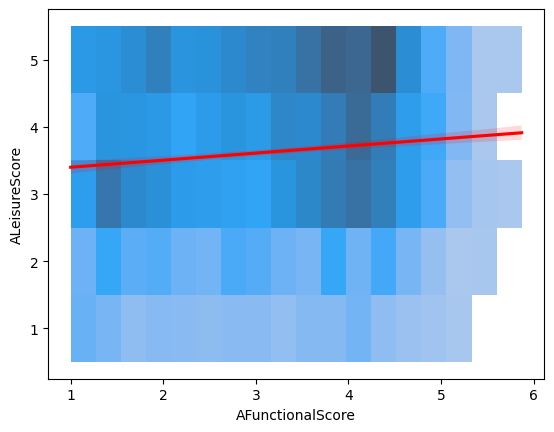

In [51]:
sns.histplot(df1, x="AFunctionalScore", y="ALeisureScore", discrete=(False, True))
sns.regplot(
    df1, x="AFunctionalScore", y="ALeisureScore", marker="", line_kws={"color": "r"}
)
plt.show()

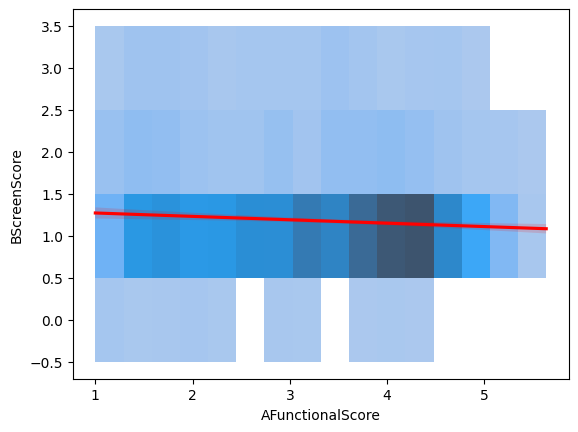

In [52]:
sns.histplot(df, x="AFunctionalScore", y="BScreenScore", discrete=(False, True))
sns.regplot(
    df, x="AFunctionalScore", y="BScreenScore", marker="", line_kws={"color": "r"}
)
plt.show()

Let's also try with the alternative functional score.

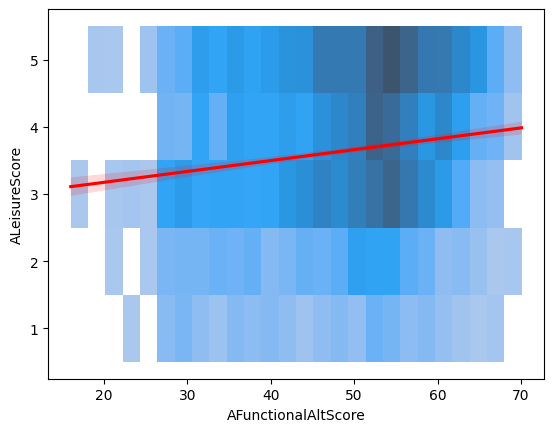

In [53]:
sns.histplot(df1, x="AFunctionalAltScore", y="ALeisureScore", discrete=(False, True))
sns.regplot(
    df1, x="AFunctionalAltScore", y="ALeisureScore", marker="", line_kws={"color": "r"}
)
plt.show()

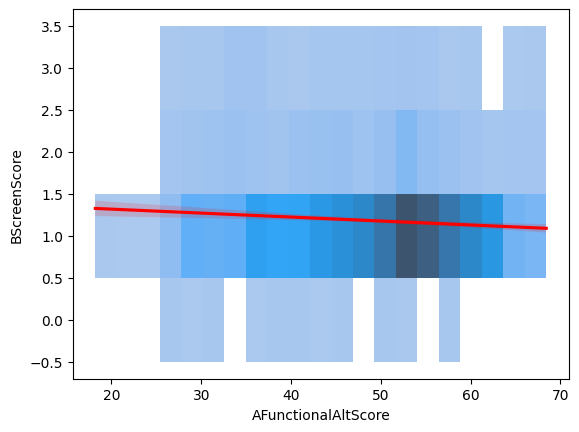

In [54]:
sns.histplot(df, x="AFunctionalAltScore", y="BScreenScore", discrete=(False, True))
sns.regplot(
    df, x="AFunctionalAltScore", y="BScreenScore", marker="", line_kws={"color": "r"}
)
plt.show()

And the other alternative score.

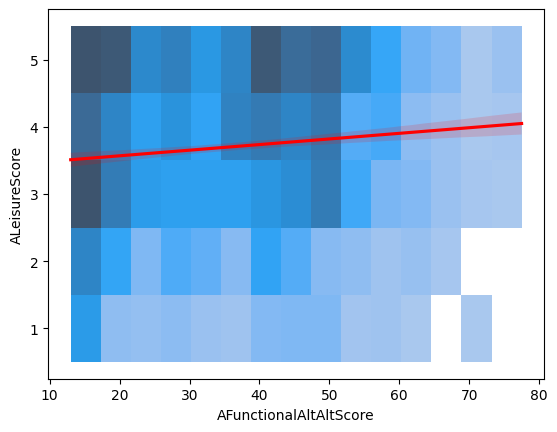

In [55]:
sns.histplot(df1, x="AFunctionalAltAltScore", y="ALeisureScore", discrete=(False, True))
sns.regplot(
    df1,
    x="AFunctionalAltAltScore",
    y="ALeisureScore",
    marker="",
    line_kws={"color": "r"},
)
plt.show()

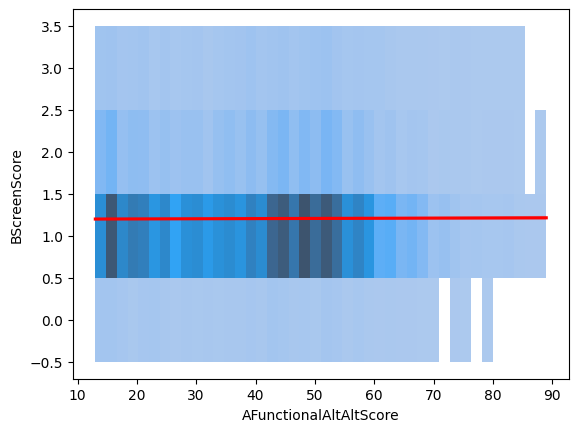

In [56]:
sns.histplot(df, x="AFunctionalAltAltScore", y="BScreenScore", discrete=(False, True))
sns.regplot(
    df, x="AFunctionalAltAltScore", y="BScreenScore", marker="", line_kws={"color": "r"}
)
plt.show()

From these plots, the general takeway is that higher functional scores seem to correlate with higher leisure and lower screen use, which makes sense.

### Question 2

> Do higher depression scores correlate with lower leisure/screen engagement?

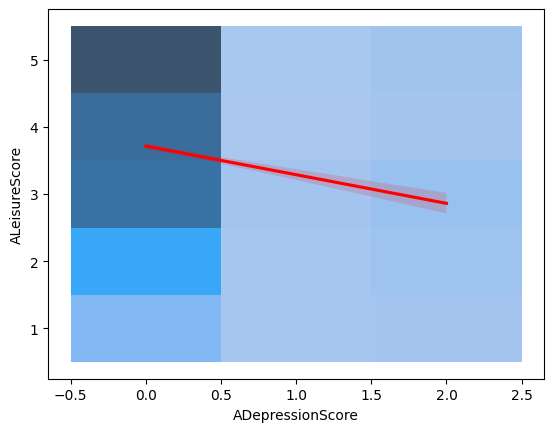

In [57]:
sns.histplot(df1, x="ADepressionScore", y="ALeisureScore", discrete=(True, True))
sns.regplot(
    df1, x="ADepressionScore", y="ALeisureScore", marker="", line_kws={"color": "r"}
)
plt.show()

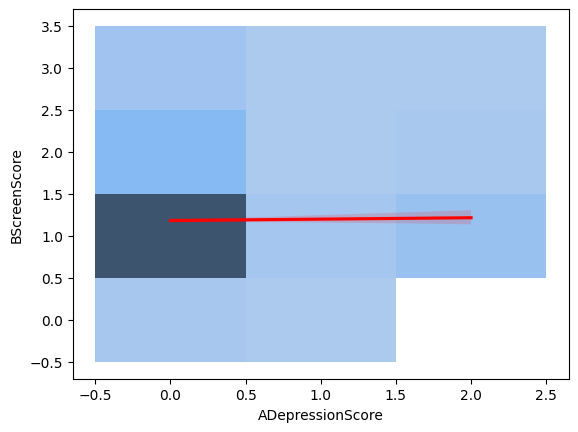

In [58]:
sns.histplot(df, x="ADepressionScore", y="BScreenScore", discrete=(True, True))
sns.regplot(
    df, x="ADepressionScore", y="BScreenScore", marker="", line_kws={"color": "r"}
)
plt.show()

Takeway: higher depression scores seem to correlate with lower leisure and slighty higher screen use. Again, seems to make sense.

### Question 3

> Are younger people more likely to engage in screen-based leisure?

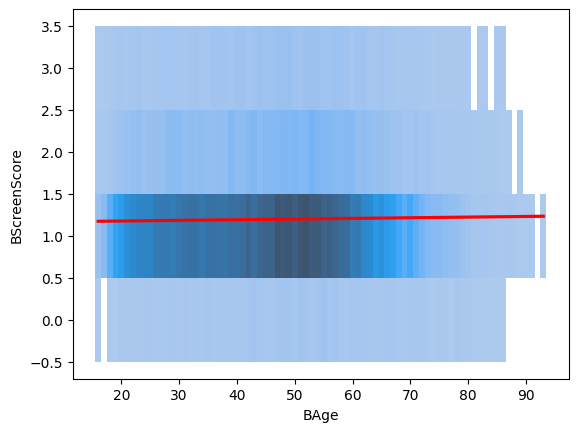

In [59]:
sub = df[df["BAge"].str.isnumeric()].copy()
sub["BAge"] = sub["BAge"].astype(int)
sns.histplot(sub, x="BAge", y="BScreenScore", discrete=(True, True))
sns.regplot(sub, x="BAge", y="BScreenScore", marker="", line_kws={"color": "r"})
plt.show()

Here the correlation between age and screen use appears low.

### Question 4

> Do mobility users report lower participation?

Note: not sure if _mobility user_ means something specific or if the question is just missing a word (_low_).

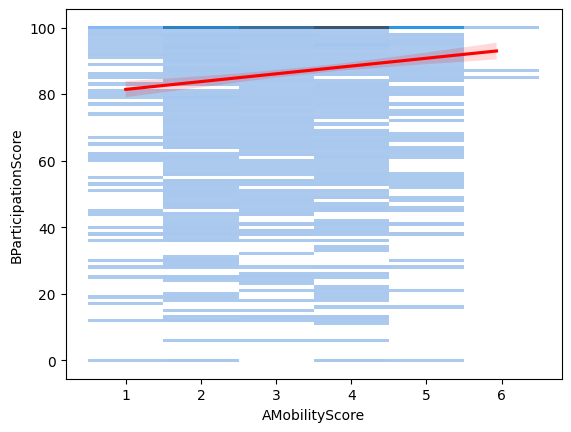

In [60]:
sns.histplot(df, x="AMobilityScore", y="BParticipationScore", discrete=(True, True))
sns.regplot(
    df, x="AMobilityScore", y="BParticipationScore", marker="", line_kws={"color": "r"}
)
plt.show()

Takeway: higher mobility score correlates with higher social participation.

### Question 5

> Is lower income associated with reduced leisure and higher depression?

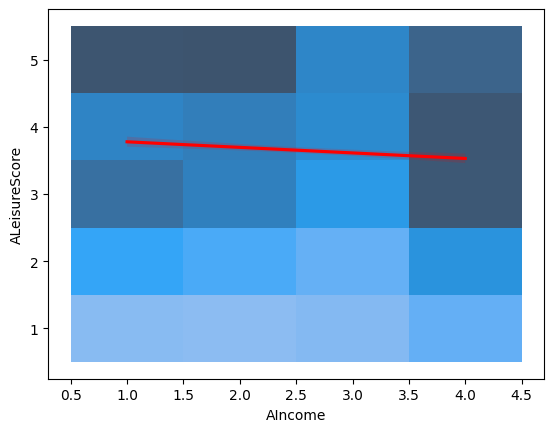

In [61]:
sns.histplot(df1, x="AIncome", y="ALeisureScore", discrete=(True, True))
sns.regplot(df1, x="AIncome", y="ALeisureScore", marker="", line_kws={"color": "r"})
plt.show()

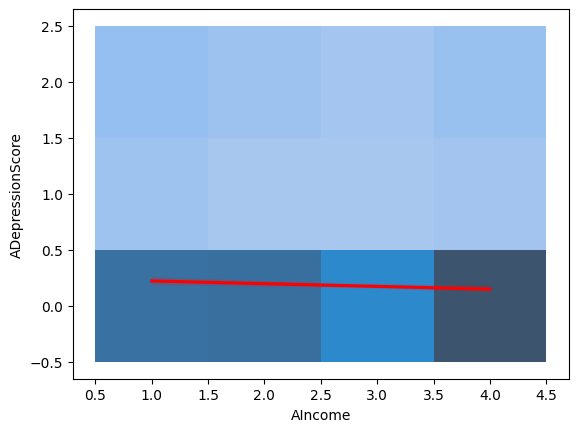

In [62]:
sns.histplot(df1, x="AIncome", y="ADepressionScore", discrete=(True, True))
sns.regplot(df1, x="AIncome", y="ADepressionScore", marker="", line_kws={"color": "r"})
plt.show()

The correlation is pretty weak but if anything, higher income seems to correlate with lower leisure and lower depression.

### Bonus: Functionality over time

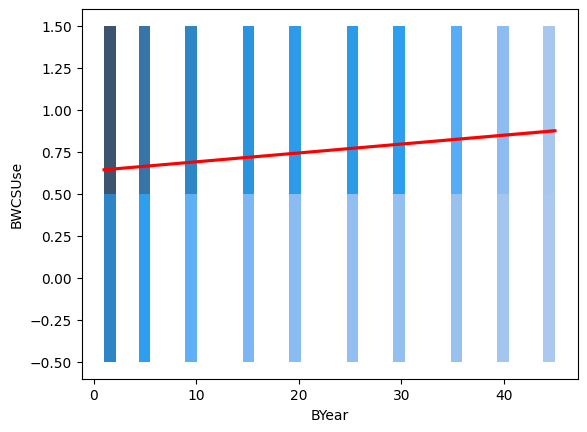

In [63]:
sns.histplot(df[df["BWCSUse"] <= 1], x="BYear", y="BWCSUse", discrete=(False, True))
sns.regplot(
    df[df["BWCSUse"] <= 1], x="BYear", y="BWCSUse", marker="", line_kws={"color": "r"}
)
plt.show()

Wheelchair/scooter use is actually increasing over time. This could mean that aging catches up faster than recovery.

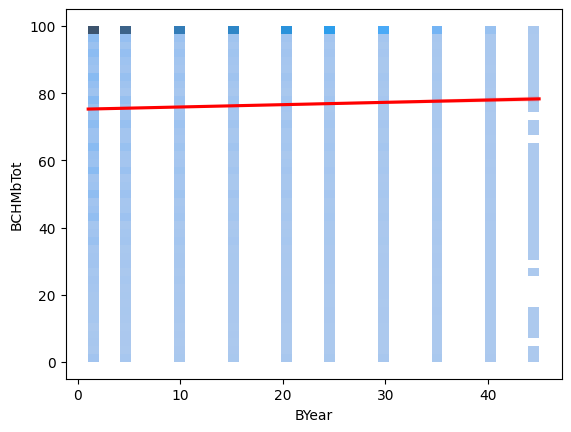

In [64]:
sns.histplot(
    df[df["BCHMbTot"] <= 100], x="BYear", y="BCHMbTot", discrete=(False, False)
)
sns.regplot(
    df[df["BCHMbTot"] <= 100],
    x="BYear",
    y="BCHMbTot",
    marker="",
    line_kws={"color": "r"},
)
plt.show()

Mobility (CHART-Mobility Total) increases slightly over time.

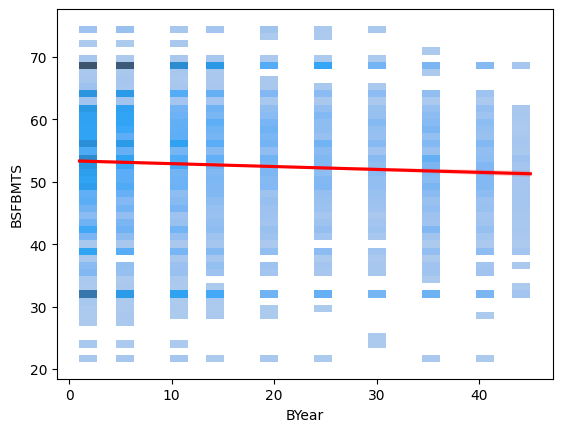

In [65]:
sns.histplot(df[df["BSFBMTS"] <= 100], x="BYear", y="BSFBMTS", discrete=(False, False))
sns.regplot(
    df[df["BSFBMTS"] <= 100], x="BYear", y="BSFBMTS", marker="", line_kws={"color": "r"}
)
plt.show()

But the Basic Mobility T-Score seems to be trending downward over time.

## Modeling

Let's now build more advanced models taking into account all the control variables.

We need to properly handle the longitudinal structure:
- Form 1 (A*) variables: Baseline characteristics (no repeated measures)
- Form 2 (B*) variables: Follow-up outcomes (repeated measures over years)

We also need to treat `UniID` as a random effect.

First let's check how the data is distributed at a high level.

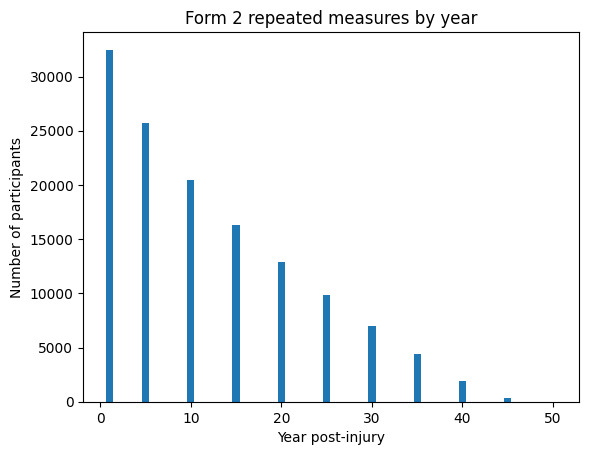

In [66]:
year_counts = df.groupby("BYear").size()
plt.bar(year_counts.index, year_counts.values)
plt.xlabel("Year post-injury")
plt.ylabel("Number of participants")
plt.title("Form 2 repeated measures by year")
plt.show()

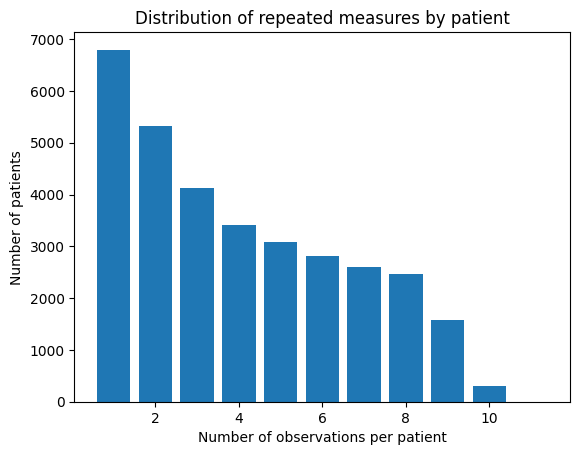

In [67]:
obs_per_patient = df.groupby("UniID").size()
counts = obs_per_patient.value_counts().sort_index()
plt.bar(counts.index, counts.values)
plt.xlabel("Number of observations per patient")
plt.ylabel("Number of patients")
plt.title("Distribution of repeated measures by patient")
plt.show()

In [68]:
print(f"Total patients: {df['UniID'].nunique()}")
print(f"Total observations: {len(df)}")
print(f"Average observations per patient: {len(df) / df['UniID'].nunique():.2f}")

Total patients: 32541
Total observations: 131217
Average observations per patient: 4.03


Now we define functions to train either a Mixed-Effect model or a linear model (OLS) and to print/plot the results.

In [69]:
def fit_longitudinal_model(
    df: pd.DataFrame, outcome: str, predictors: list[str], random_effect="UniID"
):
    """
    Fit a mixed effects model for longitudinal data.
    """
    # Prepare data
    cols_needed = [outcome] + predictors + [random_effect]
    df_model = df[cols_needed].dropna()

    if len(df_model) == 0:
        raise ValueError("No data available after removing missing values")

    # Check for repeated measures
    obs_per_group = df_model.groupby(random_effect).size()
    n_groups = len(obs_per_group)
    n_with_repeats = (obs_per_group > 1).sum()
    pct_repeats = n_with_repeats / n_groups * 100

    print(f"Data: {len(df_model)} obs, {n_groups} patients")
    print(f"Patients with 2+ observations: {n_with_repeats} ({pct_repeats:.1f}%)")

    # Prepare variables
    y = df_model[outcome]
    X = add_constant(df_model[predictors])
    groups = df_model[random_effect]

    # Try mixed model first
    try:
        model = MixedLM(y, X, groups=groups)
        result = model.fit(method="lbfgs", maxiter=200)

        # Check if random effects are essentially zero
        if hasattr(result, "cov_re"):
            re_var = result.cov_re.values[0][0]
            if re_var < 1e-6:
                print("WARNING: Random effects variance ~0, using OLS")
                model = OLS(y, X)
                result = model.fit()
                is_mixed = False
            else:
                is_mixed = True
        else:
            is_mixed = True

    except Exception as e:
        print(f"Mixed model failed ({str(e)[:50]}...), using OLS")
        model = OLS(y, X)
        result = model.fit()
        is_mixed = False

    return result, df_model, n_groups, is_mixed

In [70]:
def print_longitudinal_summary(result, model_name: str, n_groups: int, is_mixed: bool):
    """Print summary for longitudinal model."""

    model_type = "MIXED EFFECTS" if is_mixed else "OLS (POOLED)"

    print(f"\n{'=' * 80}")
    print(f"MODEL: {model_name}")
    print(f"Type: {model_type}")
    print(f"{'=' * 80}\n")
    print(f"N observations: {int(result.nobs)}")
    print(f"N patients: {n_groups}")

    if hasattr(result, "llf"):
        print(f"Log-likelihood: {result.llf:.2f}")
    if hasattr(result, "aic") and not np.isnan(result.aic):
        print(f"AIC: {result.aic:.2f}")
    if hasattr(result, "bic") and not np.isnan(result.bic):
        print(f"BIC: {result.bic:.2f}")

    print(f"\n{'-' * 80}")
    print("FIXED EFFECTS:")
    print(f"{'-' * 80}")

    params = result.params
    pvals = result.pvalues
    stderr = result.bse
    ci = result.conf_int()

    for var in params.index:
        if var == "Group Var":
            continue

        coef = params[var]
        p = pvals[var]
        se = stderr[var]
        ci_low, ci_high = ci.loc[var]
        sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""

        print(f"{var:30s}: {coef:8.4f} (SE={se:.4f}, p={p:.4f}) {sig}")
        print(f"{'':30s}  95% CI: [{ci_low:.4f}, {ci_high:.4f}]")

    if is_mixed and hasattr(result, "cov_re"):
        print(f"\n{'-' * 80}")
        print("RANDOM EFFECTS:")
        print(f"{'-' * 80}")
        group_var = result.cov_re.values[0][0]
        resid_var = result.scale
        icc = group_var / (group_var + resid_var)
        print(f"Between-patient variance: {group_var:.4f}")
        print(f"Within-patient variance: {resid_var:.4f}")
        print(f"ICC: {icc:.4f}")
    elif not is_mixed:
        print(f"\n{'-' * 80}")
        print("MODEL FIT:")
        print(f"{'-' * 80}")
        print(f"R-squared: {result.rsquared:.4f}")
        print(f"Adj. R-squared: {result.rsquared_adj:.4f}")

In [71]:
def plot_trajectories(df, outcome, predictor=None, n_sample=100):
    """Plot individual trajectories over time."""
    # Get patients with multiple observations
    obs_per_patient = df.groupby("UniID").size()
    patients_with_repeats = obs_per_patient[obs_per_patient > 1].index

    if len(patients_with_repeats) == 0:
        raise ValueError("Cannot plot: no patients with repeated measures")

    # Sample patients
    if len(patients_with_repeats) > n_sample:
        patients = np.random.choice(patients_with_repeats, n_sample, replace=False)
    else:
        patients = patients_with_repeats

    df_sample = df[df["UniID"].isin(patients)]
    cols_needed = [outcome, "BYear", "UniID"]
    if predictor:
        cols_needed.append(predictor)
    df_sample = df_sample[cols_needed].dropna()

    if len(df_sample) == 0:
        raise ValueError("No data available after removing missing values")

    axes: list[plt.Axes]
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Left plot: Individual trajectories
    for patient in patients:
        patient_data = df_sample[df_sample["UniID"] == patient].sort_values("BYear")
        if len(patient_data) > 1:
            axes[0].plot(
                patient_data["BYear"],
                patient_data[outcome],
                alpha=0.4,
                marker="o",
                markersize=3,
                linewidth=1,
            )

    axes[0].set_xlabel("Years post-injury", fontsize=11)
    axes[0].set_ylabel(outcome, fontsize=11)
    axes[0].set_title(
        f"Individual trajectories (n={len(patients)} patients)", fontsize=12
    )
    axes[0].grid(True, alpha=0.3)

    # Right plot: Mean trajectory with confidence band
    mean_by_year = df_sample.groupby("BYear")[outcome].agg(["mean", "sem", "count"])
    mean_by_year = mean_by_year[
        mean_by_year["count"] >= 5
    ]  # Only show years with 5+ obs

    years = mean_by_year.index
    means = mean_by_year["mean"]
    sems = mean_by_year["sem"]

    axes[1].plot(years, means, "b-o", linewidth=2, markersize=6, label="Mean")
    axes[1].fill_between(
        years, means - 1.96 * sems, means + 1.96 * sems, alpha=0.3, label="95% CI"
    )

    axes[1].set_xlabel("Years post-injury", fontsize=11)
    axes[1].set_ylabel(outcome, fontsize=11)
    axes[1].set_title("Average trajectory over time", fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [72]:
def plot_predictor_effects(df, outcome, predictor, time_var="BYear"):
    """Plot outcome by predictor levels over time."""
    df_plot = df[[outcome, predictor, time_var]].dropna()

    if len(df_plot) == 0:
        raise ValueError("No data available for predictor effects plot")

    # Discretize predictor into quartiles for visualization
    if df_plot[predictor].nunique() > 10:
        df_plot["pred_group"] = pd.qcut(
            df_plot[predictor],
            q=4,
            labels=["Low", "Med-Low", "Med-High", "High"],
            duplicates="drop",
        )
    else:
        df_plot["pred_group"] = df_plot[predictor]

    fig, ax = plt.subplots(figsize=(10, 6))

    for group in df_plot["pred_group"].unique():
        group_data = df_plot[df_plot["pred_group"] == group]
        mean_by_year = group_data.groupby(time_var)[outcome].mean()
        ax.plot(
            mean_by_year.index,
            mean_by_year.values,
            marker="o",
            linewidth=2,
            markersize=6,
            label=f"{predictor}={group}",
        )

    ax.set_xlabel("Years post-injury", fontsize=11)
    ax.set_ylabel(outcome, fontsize=11)
    ax.set_title(f"{outcome} by {predictor} level over time", fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Question 1: Functional score -> screen-based activities

Let's start with a simple model with just functional score and time, for reference.

In [73]:
predictors_1a = ["AFunctionalAltAltScore", "BYear"]
result_1a, df_1a, n_groups_1a, is_mixed_1a = fit_longitudinal_model(
    df, "BScreenScore", predictors_1a
)
print_longitudinal_summary(
    result_1a, "Functional + Time -> Screen (Unadjusted)", n_groups_1a, is_mixed_1a
)

Data: 21973 obs, 11634 patients
Patients with 2+ observations: 6724 (57.8%)


/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)



MODEL: Functional + Time -> Screen (Unadjusted)
Type: MIXED EFFECTS

N observations: 21973
N patients: 11634
Log-likelihood: -18376.67

--------------------------------------------------------------------------------
FIXED EFFECTS:
--------------------------------------------------------------------------------
const                         :   1.2236 (SE=0.0121, p=0.0000) ***
                                95% CI: [1.1999, 1.2473]
AFunctionalAltAltScore        :   0.0002 (SE=0.0003, p=0.4447) 
                                95% CI: [-0.0003, 0.0007]
BYear                         :  -0.0023 (SE=0.0005, p=0.0000) ***
                                95% CI: [-0.0034, -0.0012]

--------------------------------------------------------------------------------
RANDOM EFFECTS:
--------------------------------------------------------------------------------
Between-patient variance: 0.0649
Within-patient variance: 0.2544
ICC: 0.2034


Now let's incorporate some controls.

In [74]:
df_adj = df.copy()
for col in ["ASex", "ARace"]:
    df_adj[col] = pd.to_numeric(df_adj[col], errors="coerce")
    df_adj = df_adj[df_adj[col] < 7]

predictors_1b = ["AFunctionalAltAltScore", "BYear", "ASex", "ARace"]
result_1b, df_1b, n_groups_1b, is_mixed_1b = fit_longitudinal_model(
    df_adj, "BScreenScore", predictors_1b
)
print_longitudinal_summary(
    result_1b, "Functional + Time -> Screen (Adjusted)", n_groups_1b, is_mixed_1b
)

Data: 21518 obs, 11367 patients
Patients with 2+ observations: 6582 (57.9%)


/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)



MODEL: Functional + Time -> Screen (Adjusted)
Type: MIXED EFFECTS

N observations: 21518
N patients: 11367
Log-likelihood: -17924.15

--------------------------------------------------------------------------------
FIXED EFFECTS:
--------------------------------------------------------------------------------
const                         :   1.1823 (SE=0.0190, p=0.0000) ***
                                95% CI: [1.1451, 1.2195]
AFunctionalAltAltScore        :   0.0001 (SE=0.0003, p=0.6051) 
                                95% CI: [-0.0004, 0.0007]
BYear                         :  -0.0024 (SE=0.0006, p=0.0000) ***
                                95% CI: [-0.0035, -0.0014]
ASex                          :   0.0121 (SE=0.0102, p=0.2372) 
                                95% CI: [-0.0079, 0.0320]
ARace                         :   0.0208 (SE=0.0050, p=0.0000) ***
                                95% CI: [0.0111, 0.0306]

---------------------------------------------------------------------

We can plot trajectories.

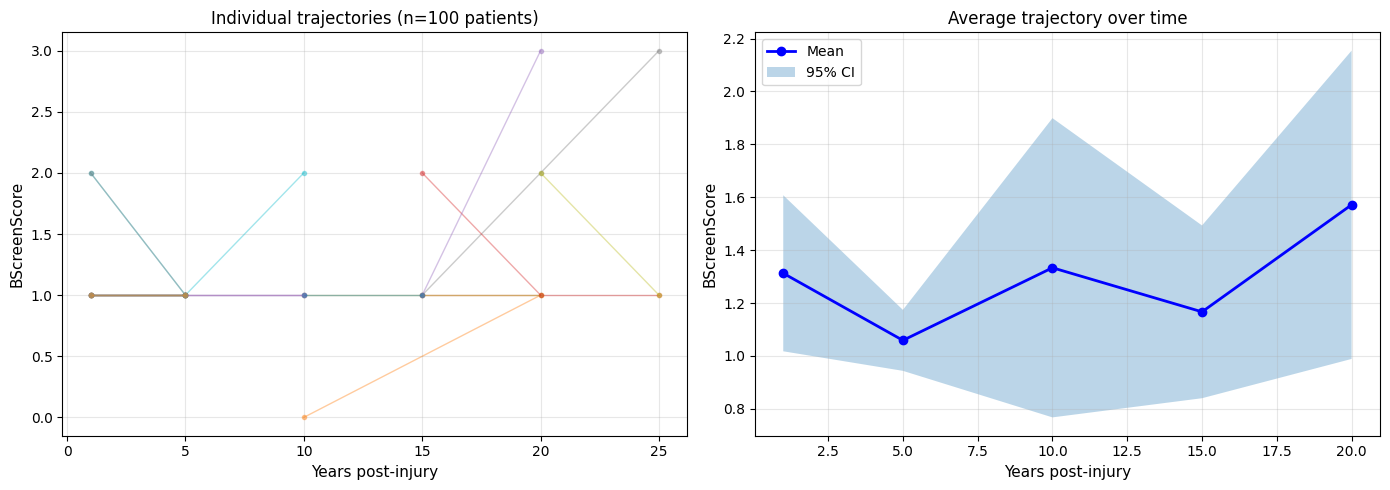

In [75]:
plot_trajectories(df, "BScreenScore", "AFunctionalAltAltScore")

And we can plot functional score effects over time.

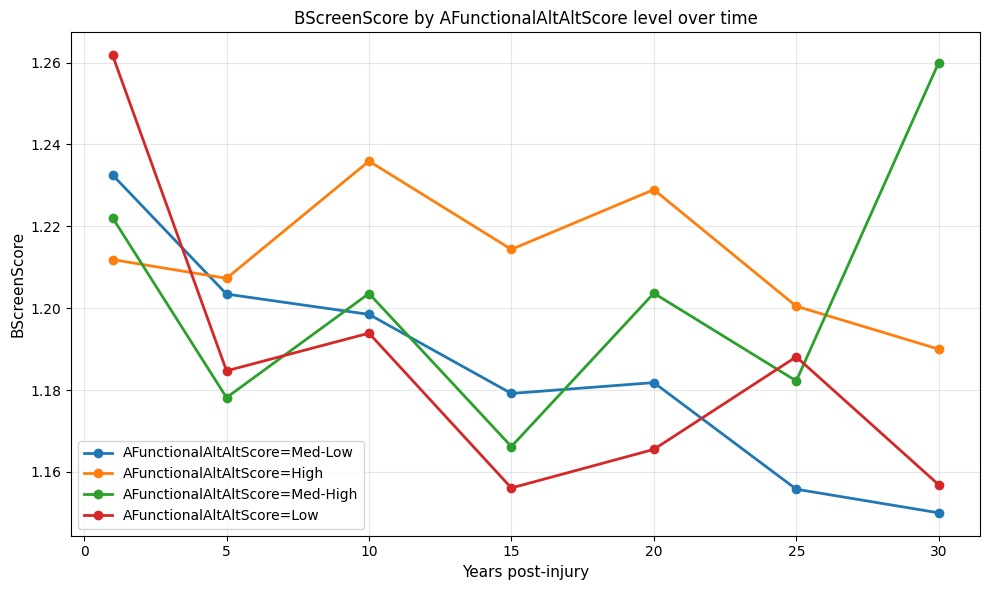

In [76]:
plot_predictor_effects(df, "BScreenScore", "AFunctionalAltAltScore")

### Question 2: Depression vs screen activities

Again, starting with a simple model without controls.

In [77]:
predictors_2a = ["ADepressionScore", "BYear"]
result_2a, df_2a, n_groups_2a, is_mixed_2a = fit_longitudinal_model(
    df, "BScreenScore", predictors_2a
)
print_longitudinal_summary(
    result_2a, "Depression + Time -> Screen (Unadjusted)", n_groups_2a, is_mixed_2a
)

Data: 1754 obs, 1747 patients
Patients with 2+ observations: 7 (0.4%)


/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)



MODEL: Depression + Time -> Screen (Unadjusted)
Type: OLS (POOLED)

N observations: 1754
N patients: 1747
Log-likelihood: -1316.55
AIC: 2639.11
BIC: 2655.52

--------------------------------------------------------------------------------
FIXED EFFECTS:
--------------------------------------------------------------------------------
const                         :   1.1273 (SE=0.0436, p=0.0000) ***
                                95% CI: [1.0417, 1.2129]
ADepressionScore              :   0.0174 (SE=0.0237, p=0.4644) 
                                95% CI: [-0.0292, 0.0639]
BYear                         :   0.0545 (SE=0.0407, p=0.1802) 
                                95% CI: [-0.0253, 0.1343]

--------------------------------------------------------------------------------
MODEL FIT:
--------------------------------------------------------------------------------
R-squared: 0.0013
Adj. R-squared: 0.0002


/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Then a model including controls.

In [78]:
predictors_2b = ["ADepressionScore", "BYear", "AFunctionalAltAltScore"]
result_2b, df_2b, n_groups_2b, is_mixed_2b = fit_longitudinal_model(
    df, "BScreenScore", predictors_2b
)
print_longitudinal_summary(
    result_2b, "Depression + Time -> Screen (Adjusted)", n_groups_2b, is_mixed_2b
)

/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


Data: 1236 obs, 1229 patients
Patients with 2+ observations: 7 (0.6%)

MODEL: Depression + Time -> Screen (Adjusted)
Type: MIXED EFFECTS

N observations: 1236
N patients: 1229
Log-likelihood: -1017.51

--------------------------------------------------------------------------------
FIXED EFFECTS:
--------------------------------------------------------------------------------
const                         :   1.2412 (SE=0.0643, p=0.0000) ***
                                95% CI: [1.1150, 1.3673]
ADepressionScore              :   0.0151 (SE=0.0301, p=0.6164) 
                                95% CI: [-0.0439, 0.0740]
BYear                         :   0.0418 (SE=0.0439, p=0.3413) 
                                95% CI: [-0.0443, 0.1279]
AFunctionalAltAltScore        :  -0.0021 (SE=0.0011, p=0.0475) *
                                95% CI: [-0.0042, -0.0000]

--------------------------------------------------------------------------------
RANDOM EFFECTS:
-------------------------------

/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Depression data has very few repeated measures (7 patients, or 0.6%). We should consider a cross-sectional analysis rather than longitudinal.

#### Question 3: Age vs screen activities

In [79]:
# Convert age to numeric
df_age = df.copy()
df_age["BAge_numeric"] = pd.to_numeric(df_age["BAge"], errors="coerce")
df_age = df_age[df_age["BAge_numeric"].notna()]

predictors_3a = ["BAge_numeric", "BYear"]
result_3a, df_3a, n_groups_3a, is_mixed_3a = fit_longitudinal_model(
    df_age, "BScreenScore", predictors_3a
)
print_longitudinal_summary(
    result_3a, "Age + Time -> Screen (Unadjusted)", n_groups_3a, is_mixed_3a
)

Data: 29342 obs, 15348 patients
Patients with 2+ observations: 8852 (57.7%)


/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)



MODEL: Age + Time -> Screen (Unadjusted)
Type: MIXED EFFECTS

N observations: 29342
N patients: 15348
Log-likelihood: -24100.23

--------------------------------------------------------------------------------
FIXED EFFECTS:
--------------------------------------------------------------------------------
const                         :   1.1669 (SE=0.0117, p=0.0000) ***
                                95% CI: [1.1441, 1.1898]
BAge_numeric                  :   0.0015 (SE=0.0003, p=0.0000) ***
                                95% CI: [0.0010, 0.0020]
BYear                         :  -0.0024 (SE=0.0003, p=0.0000) ***
                                95% CI: [-0.0030, -0.0017]

--------------------------------------------------------------------------------
RANDOM EFFECTS:
--------------------------------------------------------------------------------
Between-patient variance: 0.0662
Within-patient variance: 0.2447
ICC: 0.2130


In [80]:
# Note: Age changes with time, creating collinearity with BYear
# Better to use age at injury (AInjAge)
df_age2 = df.copy()
df_age2["AInjAge_numeric"] = pd.to_numeric(df_age2["AInjAge"], errors="coerce")
df_age2 = df_age2[df_age2["AInjAge_numeric"].notna()]

predictors_3b = ["AInjAge_numeric", "BYear"]
result_3b, df_3b, n_groups_3b, is_mixed_3b = fit_longitudinal_model(
    df_age2, "BScreenScore", predictors_3b
)
print_longitudinal_summary(
    result_3b, "Age at Injury + Time -> Screen", n_groups_3b, is_mixed_3b
)

Data: 29342 obs, 15348 patients
Patients with 2+ observations: 8852 (57.7%)


/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)



MODEL: Age at Injury + Time -> Screen
Type: MIXED EFFECTS

N observations: 29342
N patients: 15348
Log-likelihood: -24100.23

--------------------------------------------------------------------------------
FIXED EFFECTS:
--------------------------------------------------------------------------------
const                         :   1.1669 (SE=0.0117, p=0.0000) ***
                                95% CI: [1.1441, 1.1898]
AInjAge_numeric               :   0.0015 (SE=0.0003, p=0.0000) ***
                                95% CI: [0.0010, 0.0020]
BYear                         :  -0.0009 (SE=0.0003, p=0.0064) **
                                95% CI: [-0.0015, -0.0003]

--------------------------------------------------------------------------------
RANDOM EFFECTS:
--------------------------------------------------------------------------------
Between-patient variance: 0.0662
Within-patient variance: 0.2447
ICC: 0.2130


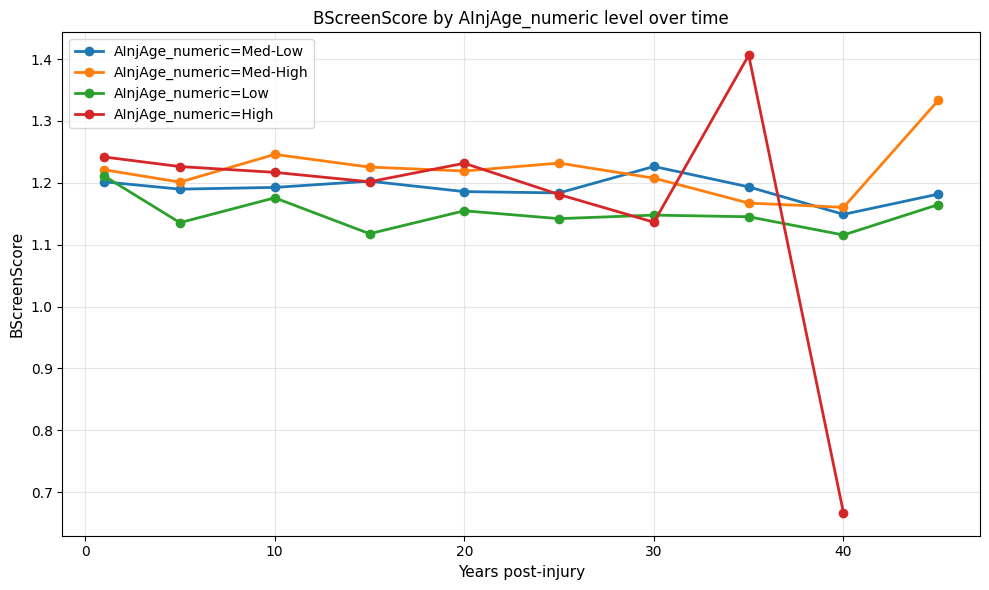

In [81]:
plot_predictor_effects(df_age2, "BScreenScore", "AInjAge_numeric")

#### Question 4: Mobility vs participation

In [82]:
predictors_4a = ["AMobilityScore", "BYear"]
result_4a, df_4a, n_groups_4a, is_mixed_4a = fit_longitudinal_model(
    df, "BParticipationScore", predictors_4a
)
print_longitudinal_summary(
    result_4a, "Mobility + Time -> Participation (Unadjusted)", n_groups_4a, is_mixed_4a
)

Data: 1790 obs, 1787 patients
Patients with 2+ observations: 3 (0.2%)


/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)



MODEL: Mobility + Time -> Participation (Unadjusted)
Type: MIXED EFFECTS

N observations: 1790
N patients: 1787
Log-likelihood: -8109.43

--------------------------------------------------------------------------------
FIXED EFFECTS:
--------------------------------------------------------------------------------
const                         :  77.4119 (SE=1.9080, p=0.0000) ***
                                95% CI: [73.6723, 81.1516]
AMobilityScore                :   2.3509 (SE=0.4721, p=0.0000) ***
                                95% CI: [1.4255, 3.2763]
BYear                         :   1.6207 (SE=0.9029, p=0.0726) 
                                95% CI: [-0.1488, 3.3903]

--------------------------------------------------------------------------------
RANDOM EFFECTS:
--------------------------------------------------------------------------------
Between-patient variance: 12.9721
Within-patient variance: 493.4167
ICC: 0.0256


/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.116458
  warnings.warn(msg, ConvergenceWarning)
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [83]:
predictors_4b = ["AMobilityScore", "BYear", "ADepressionScore"]
result_4b, df_4b, n_groups_4b, is_mixed_4b = fit_longitudinal_model(
    df, "BParticipationScore", predictors_4b
)
print_longitudinal_summary(
    result_4b, "Mobility + Time -> Participation (Adjusted)", n_groups_4b, is_mixed_4b
)

Data: 1714 obs, 1712 patients
Patients with 2+ observations: 2 (0.1%)


/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)



MODEL: Mobility + Time -> Participation (Adjusted)
Type: MIXED EFFECTS

N observations: 1714
N patients: 1712
Log-likelihood: -7751.84

--------------------------------------------------------------------------------
FIXED EFFECTS:
--------------------------------------------------------------------------------
const                         :  79.7698 (SE=2.4600, p=0.0000) ***
                                95% CI: [74.9482, 84.5913]
AMobilityScore                :   2.0733 (SE=0.4780, p=0.0000) ***
                                95% CI: [1.1363, 3.0103]
BYear                         :   0.7356 (SE=1.7832, p=0.6800) 
                                95% CI: [-2.7594, 4.2306]
ADepressionScore              :  -2.3644 (SE=1.0499, p=0.0243) *
                                95% CI: [-4.4222, -0.3066]

--------------------------------------------------------------------------------
RANDOM EFFECTS:
--------------------------------------------------------------------------------
Between-pat

/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [84]:
# plot_trajectories(df, "BParticipationScore", "AMobilityScore")

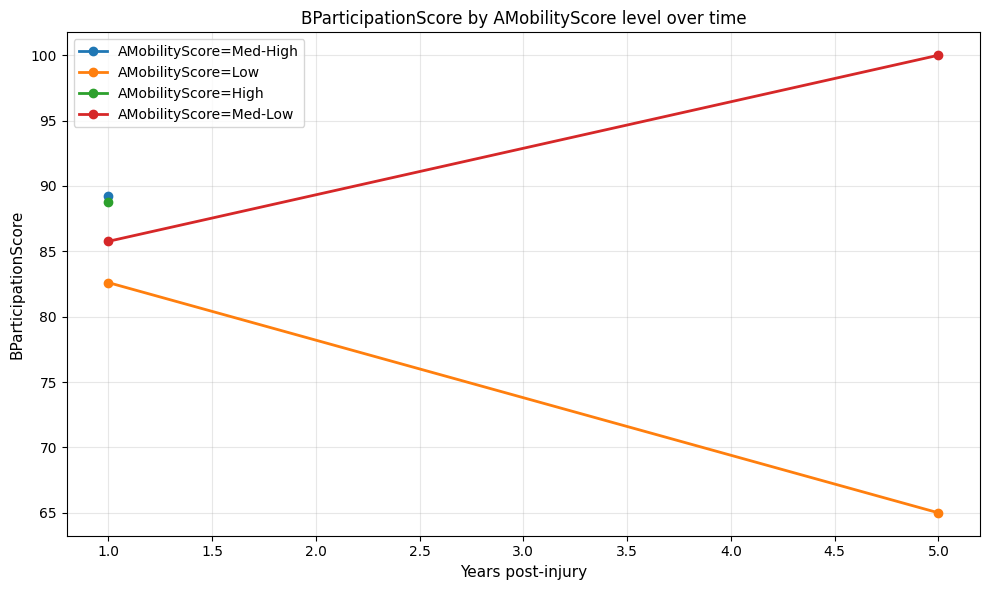

In [85]:
plot_predictor_effects(df, "BParticipationScore", "AMobilityScore")

#### Question 5: Income effects

Note that `BIncome` changes over time, so we can model it longitudinally but we need the outcome to also be from Form 2.

##### Screen activities

In [86]:
df_inc = df.copy()
df_inc["BIncome"] = pd.to_numeric(df_inc["BIncome"], errors="coerce")
df_inc = df_inc[df_inc["BIncome"].notna()]

predictors_5a = ["BIncome", "BYear"]
result_5a, df_5a, n_groups_5a, is_mixed_5a = fit_longitudinal_model(
    df_inc, "BScreenScore", predictors_5a
)
print_longitudinal_summary(
    result_5a, "Income + Time -> Screen", n_groups_5a, is_mixed_5a
)

Data: 19324 obs, 12613 patients
Patients with 2+ observations: 5736 (45.5%)


/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)



MODEL: Income + Time -> Screen
Type: MIXED EFFECTS

N observations: 19324
N patients: 12613
Log-likelihood: -15299.30

--------------------------------------------------------------------------------
FIXED EFFECTS:
--------------------------------------------------------------------------------
const                         :   1.3632 (SE=0.0097, p=0.0000) ***
                                95% CI: [1.3441, 1.3823]
BIncome                       :  -0.0681 (SE=0.0034, p=0.0000) ***
                                95% CI: [-0.0747, -0.0615]
BYear                         :  -0.0007 (SE=0.0003, p=0.0462) *
                                95% CI: [-0.0013, -0.0000]

--------------------------------------------------------------------------------
RANDOM EFFECTS:
--------------------------------------------------------------------------------
Between-patient variance: 0.0647
Within-patient variance: 0.2256
ICC: 0.2229


##### Participation

In [87]:
predictors_5b = ["BIncome", "BYear"]
result_5b, df_5b, n_groups_5b, is_mixed_5b = fit_longitudinal_model(
    df_inc, "BParticipationScore", predictors_5b
)
print_longitudinal_summary(
    result_5b, "Income + Time -> Participation", n_groups_5b, is_mixed_5b
)

Data: 30436 obs, 17007 patients
Patients with 2+ observations: 8858 (52.1%)


/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)



MODEL: Income + Time -> Participation
Type: MIXED EFFECTS

N observations: 30436
N patients: 17007
Log-likelihood: -135249.99

--------------------------------------------------------------------------------
FIXED EFFECTS:
--------------------------------------------------------------------------------
const                         :  77.4484 (SE=0.3070, p=0.0000) ***
                                95% CI: [76.8468, 78.0500]
BIncome                       :   5.2270 (SE=0.1153, p=0.0000) ***
                                95% CI: [5.0011, 5.4530]
BYear                         :  -0.1556 (SE=0.0116, p=0.0000) ***
                                95% CI: [-0.1785, -0.1328]

--------------------------------------------------------------------------------
RANDOM EFFECTS:
--------------------------------------------------------------------------------
Between-patient variance: 199.2427
Within-patient variance: 270.8938
ICC: 0.4238


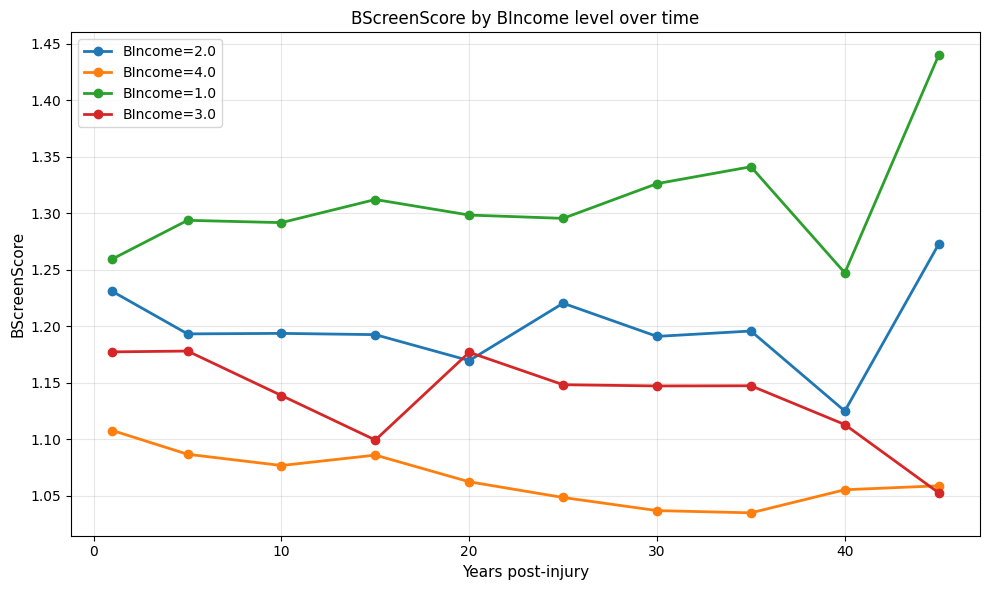

In [88]:
plot_predictor_effects(df_inc, "BScreenScore", "BIncome")

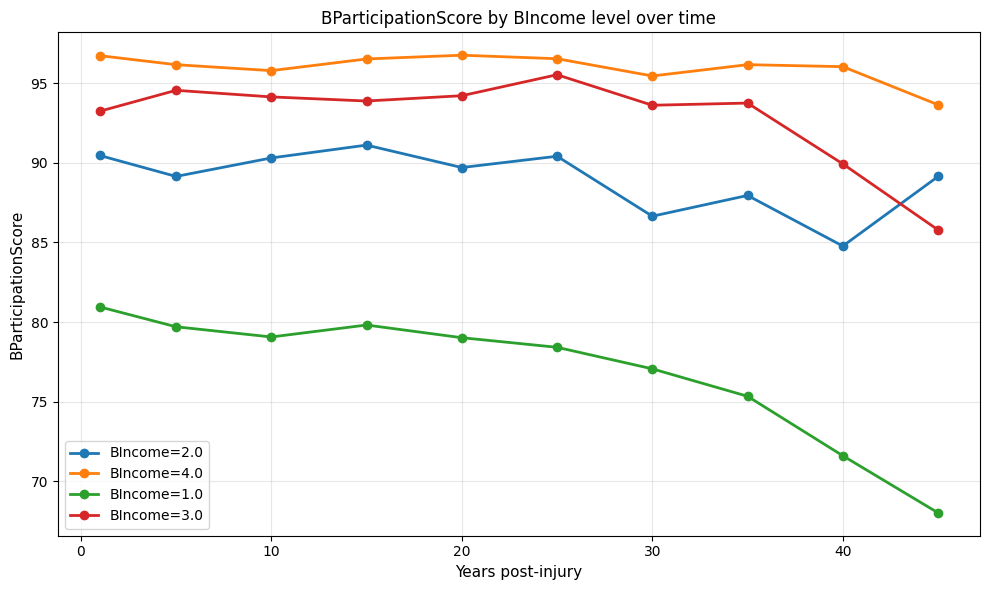

In [89]:
plot_predictor_effects(df_inc, "BParticipationScore", "BIncome")

Let's summarize all our finding so far.

In [90]:
summary_data = []

all_models = [
    ("Functional -> Screen (Unadj)", result_1a, n_groups_1a, is_mixed_1a),
    ("Functional -> Screen (Adj)", result_1b, n_groups_1b, is_mixed_1b),
    ("Depression -> Screen (Unadj)", result_2a, n_groups_2a, is_mixed_2a),
    ("Depression -> Screen (Adj)", result_2b, n_groups_2b, is_mixed_2b),
    ("Age -> Screen (Current)", result_3a, n_groups_3a, is_mixed_3a),
    ("Age at Injury -> Screen", result_3b, n_groups_3b, is_mixed_3b),
    ("Mobility -> Participation (Unadj)", result_4a, n_groups_4a, is_mixed_4a),
    ("Mobility -> Participation (Adj)", result_4b, n_groups_4b, is_mixed_4b),
    ("Income -> Screen", result_5a, n_groups_5a, is_mixed_5a),
    ("Income -> Participation", result_5b, n_groups_5b, is_mixed_5b),
]

for model_name, result, n_groups, is_mixed in all_models:
    if result is not None:
        params = result.params.copy()
        pvals = result.pvalues.copy()

        # Remove intercept
        if "const" in params.index:
            params = params.drop("const")
            pvals = pvals.drop("const")
        if "Group Var" in params.index:
            params = params.drop("Group Var")
            pvals = pvals.drop("Group Var")

        # Get main predictor (first) and time effect
        main_pred = params.index[0]
        main_coef = params[main_pred]
        main_pval = pvals[main_pred]

        time_coef = params["BYear"] if "BYear" in params.index else np.nan
        time_pval = pvals["BYear"] if "BYear" in pvals.index else np.nan

        summary_data.append(
            {
                "Model": model_name,
                "Type": "Mixed" if is_mixed else "Pooled",
                "Main Pred": main_pred,
                "Main Coef": f"{main_coef:.4f}",
                "Main p": f"{main_pval:.4f}",
                "Main Sig": "***"
                if main_pval < 0.001
                else "**"
                if main_pval < 0.01
                else "*"
                if main_pval < 0.05
                else "",
                "Time Coef": f"{time_coef:.4f}" if not np.isnan(time_coef) else "N/A",
                "Time p": f"{time_pval:.4f}" if not np.isnan(time_pval) else "N/A",
                "Time Sig": (
                    "***"
                    if time_pval < 0.001
                    else "**"
                    if time_pval < 0.01
                    else "*"
                    if time_pval < 0.05
                    else ""
                )
                if not np.isnan(time_pval)
                else "",
                "N obs": int(result.nobs),
                "N pts": n_groups,
            }
        )

summary_df = pd.DataFrame(summary_data)
print("\n")
print(summary_df.to_string(index=False))
print("\n*** p<0.001, ** p<0.01, * p<0.05")



                            Model   Type              Main Pred Main Coef Main p Main Sig Time Coef Time p Time Sig  N obs  N pts
     Functional -> Screen (Unadj)  Mixed AFunctionalAltAltScore    0.0002 0.4447            -0.0023 0.0000      ***  21973  11634
       Functional -> Screen (Adj)  Mixed AFunctionalAltAltScore    0.0001 0.6051            -0.0024 0.0000      ***  21518  11367
     Depression -> Screen (Unadj) Pooled       ADepressionScore    0.0174 0.4644             0.0545 0.1802            1754   1747
       Depression -> Screen (Adj)  Mixed       ADepressionScore    0.0151 0.6164             0.0418 0.3413            1236   1229
          Age -> Screen (Current)  Mixed           BAge_numeric    0.0015 0.0000      ***   -0.0024 0.0000      ***  29342  15348
          Age at Injury -> Screen  Mixed        AInjAge_numeric    0.0015 0.0000      ***   -0.0009 0.0064       **  29342  15348
Mobility -> Participation (Unadj)  Mixed         AMobilityScore    2.3509 0.0000      **

And compare the coefficients.

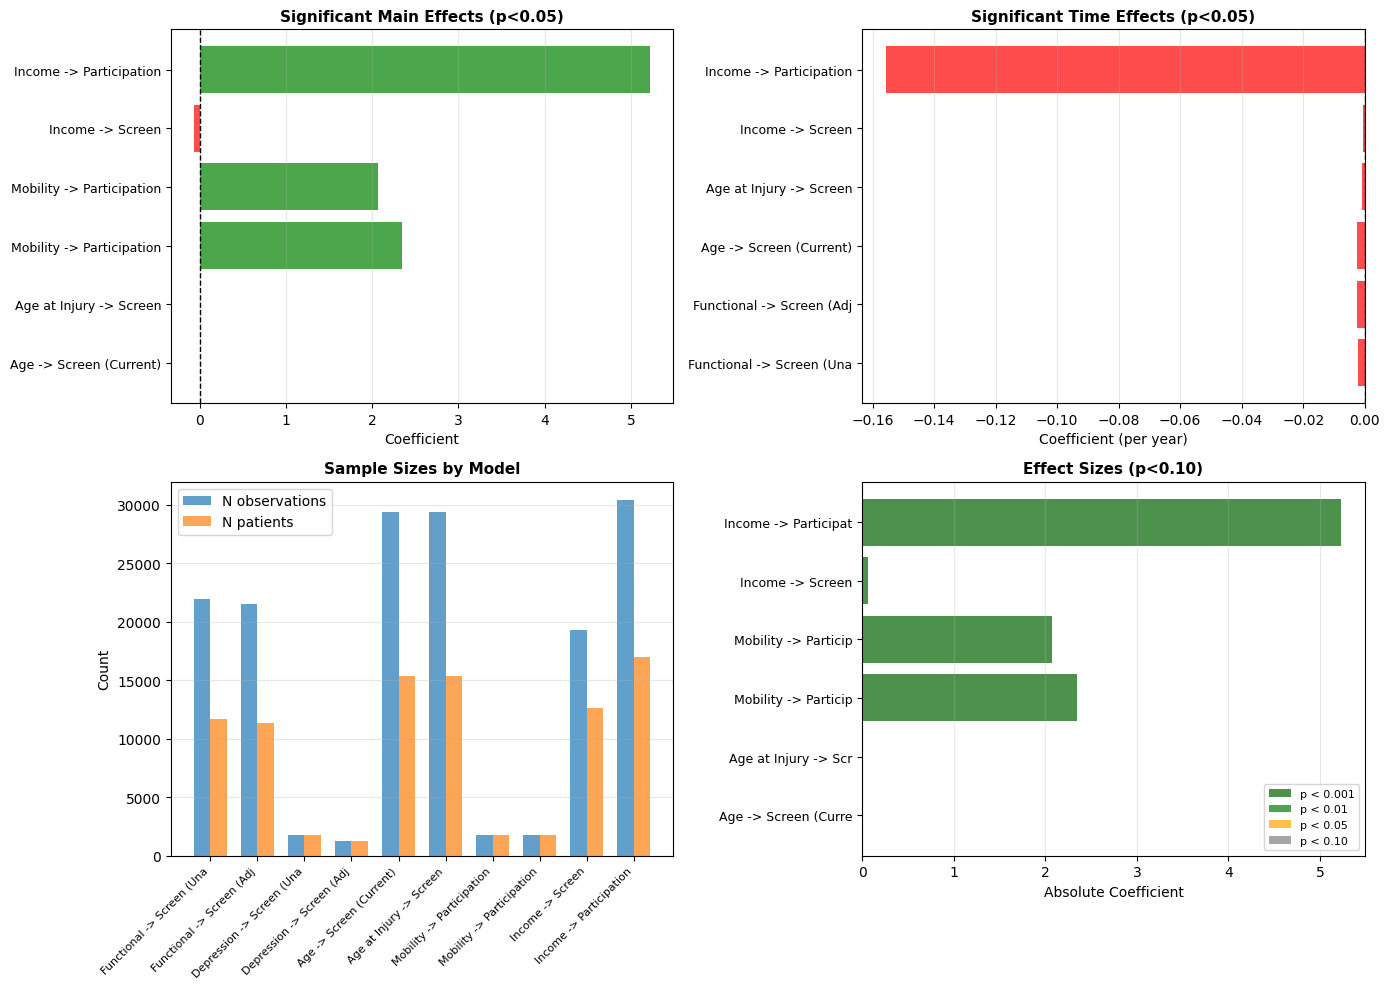

In [91]:
# Create coefficient comparison plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Main predictors
ax = axes[0, 0]
main_effects = []
main_names = []
main_colors = []
for row in summary_data:
    if row["Main p"] != "N/A" and float(row["Main p"]) < 0.05:
        main_effects.append(float(row["Main Coef"]))
        main_names.append(row["Model"][:25])  # Truncate long names
        main_colors.append("green" if float(row["Main Coef"]) > 0 else "red")

if main_effects:
    y_pos = np.arange(len(main_effects))
    ax.barh(y_pos, main_effects, color=main_colors, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(main_names, fontsize=9)
    ax.set_xlabel("Coefficient", fontsize=10)
    ax.set_title("Significant Main Effects (p<0.05)", fontsize=11, fontweight="bold")
    ax.axvline(x=0, color="black", linestyle="--", linewidth=1)
    ax.grid(True, alpha=0.3, axis="x")

# 2. Time effects
ax = axes[0, 1]
time_effects = []
time_names = []
time_colors = []
for row in summary_data:
    if row["Time p"] != "N/A" and float(row["Time p"]) < 0.05:
        time_effects.append(float(row["Time Coef"]))
        time_names.append(row["Model"][:25])
        time_colors.append("green" if float(row["Time Coef"]) > 0 else "red")

if time_effects:
    y_pos = np.arange(len(time_effects))
    ax.barh(y_pos, time_effects, color=time_colors, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(time_names, fontsize=9)
    ax.set_xlabel("Coefficient (per year)", fontsize=10)
    ax.set_title("Significant Time Effects (p<0.05)", fontsize=11, fontweight="bold")
    ax.axvline(x=0, color="black", linestyle="--", linewidth=1)
    ax.grid(True, alpha=0.3, axis="x")

# 3. Sample sizes
ax = axes[1, 0]
model_names_short = [row["Model"][:25] for row in summary_data]
n_obs = [row["N obs"] for row in summary_data]
n_pts = [row["N pts"] for row in summary_data]

x = np.arange(len(model_names_short))
width = 0.35
ax.bar(x - width / 2, n_obs, width, label="N observations", alpha=0.7)
ax.bar(x + width / 2, n_pts, width, label="N patients", alpha=0.7)
ax.set_ylabel("Count", fontsize=10)
ax.set_title("Sample Sizes by Model", fontsize=11, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(model_names_short, rotation=45, ha="right", fontsize=8)
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

# 4. Effect sizes comparison
ax = axes[1, 1]
# Calculate standardized effects (just for comparison purposes)
effect_comparison = []
for row in summary_data:
    if row["Main p"] != "N/A" and float(row["Main p"]) < 0.10:  # Include marginal
        effect_comparison.append(
            {
                "model": row["Model"][:20],
                "coef": abs(float(row["Main Coef"])),
                "sig": float(row["Main p"]),
            }
        )

if effect_comparison:
    models = [e["model"] for e in effect_comparison]
    coefs = [e["coef"] for e in effect_comparison]
    colors_sig = [
        "darkgreen"
        if e["sig"] < 0.001
        else "green"
        if e["sig"] < 0.01
        else "orange"
        if e["sig"] < 0.05
        else "gray"
        for e in effect_comparison
    ]

    y_pos = np.arange(len(models))
    ax.barh(y_pos, coefs, color=colors_sig, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(models, fontsize=9)
    ax.set_xlabel("Absolute Coefficient", fontsize=10)
    ax.set_title("Effect Sizes (p<0.10)", fontsize=11, fontweight="bold")
    ax.grid(True, alpha=0.3, axis="x")

    # Add legend for significance
    from matplotlib.patches import Patch

    legend_elements = [
        Patch(facecolor="darkgreen", alpha=0.7, label="p < 0.001"),
        Patch(facecolor="green", alpha=0.7, label="p < 0.01"),
        Patch(facecolor="orange", alpha=0.7, label="p < 0.05"),
        Patch(facecolor="gray", alpha=0.7, label="p < 0.10"),
    ]
    ax.legend(handles=legend_elements, loc="lower right", fontsize=8)

plt.tight_layout()
plt.show()

### Interpretation of findings

1. **Functional score → screen activities**
   - Main effect: Not significant (p>0.05)
   - Time effect: Significant DECREASE over years (p<0.001)
   - → Functional ability at injury doesn't predict screen use
   - → But screen use DECREASES over time for everyone

2. **Depression → screen activities**
   - Limited repeated measures data (caution in interpretation)
   - Main effect: Not significant
   - → Depression at injury doesn't predict later screen use

3. **Age → screen activities**
   - Main effect: POSITIVE (p<0.001)
   - Time effect: NEGATIVE (p<0.01)
   - → Older people at injury have MORE screen use
   - → But screen use DECREASES over recovery years

4. **Mobility → participation**
   - Main effect: POSITIVE and strong (p<0.001)
   - Effect size: ~2.3 points increase per unit mobility
   - → Better mobility strongly predicts social participation

5. **Income → outcomes**
   - Income → Screen: NEGATIVE (p<0.001)
   - Income → Participation: POSITIVE (p<0.001)
   - → Higher income = less screen time, more social participation
   - → Consistent with expectations about social engagement